In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import seaborn as sns
import os
import pickle
from tqdm import tqdm
import networkx as nx

In [2]:
import os
import psutil
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from IPython.display import clear_output
from tools.opera_tools import plot_graphx, DISTANCE
process = psutil.Process(os.getpid())

/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.2 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


## HDBSCAN для нахождения ливней

HDBSCAN это как DBSCAN, но лучше. 

## Читаем граф с вершинами

In [3]:
%%time
graphx = nx.read_gpickle('./data/clean_brick_0.pkl')

CPU times: user 420 ms, sys: 92 ms, total: 512 ms
Wall time: 510 ms


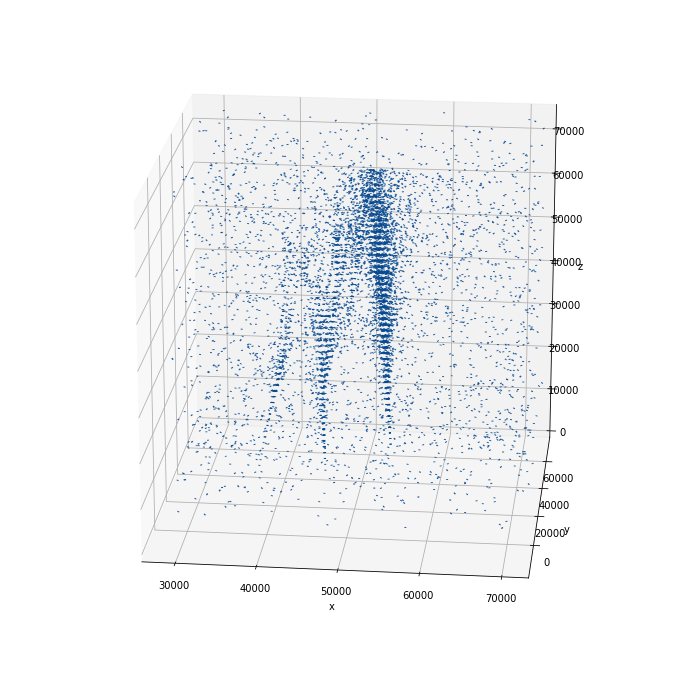

In [4]:
plot_graphx(graphx=graphx, elev=20)

## Функция подсчёта метрики

In [5]:
DISTANCE

1293.0

In [6]:
from math import fabs, sqrt, log

def rms_integral_root_closed(basetrack_left, basetrack_right, 
                             TX_LEFT='TX', TY_LEFT='TY',
                             TX_RIGHT='TX', TY_RIGHT='TY'):
    dz = basetrack_right['features']['SZ'] - basetrack_left['features']['SZ']
    dx = basetrack_left['features']['SX'] - (basetrack_right['features']['SX'] - basetrack_right['features'][TX_RIGHT] * dz)
    dy = basetrack_left['features']['SY'] - (basetrack_right['features']['SY'] - basetrack_right['features'][TY_RIGHT] * dz)
    dtx = (basetrack_left['features'][TX_LEFT] - basetrack_right['features'][TX_RIGHT])
    dty = (basetrack_left['features'][TX_LEFT] - basetrack_right['features'][TY_RIGHT])
    # dz can be assigned to arbitrary value, acutally !
    dz = DISTANCE
    a = (dtx * dz) ** 2 + (dty * dz) ** 2
    b = 2 * (dtx * dz * dx +  dty * dz * dy)
    c = dx ** 2 + dy ** 2
    if a == 0.:
        return fabs(sqrt(c))
    discriminant = (b ** 2 - 4 * a * c)
    log_denominator = 2 * sqrt(a) * sqrt(a + b + c) + 2 * a + b 
    log_numerator = 2 * sqrt(a) * sqrt(c) + b
    first_part = ( (2 * a + b) * sqrt(a + b + c) - b * sqrt(c) ) / (4 * a)
    return fabs((discriminant * log(log_numerator / log_denominator) / (8 * sqrt(a * a * a)) + first_part))

## Подсчёт матрицы расстояний

Матрица расстояний считается для всех пар треков, таких что один трек следует за другим. 

То есть если трек_1 в пластине 1, а трек_2 в пластине 2, то они будут соединены ребром от трека_1 до трека_2, но ребра от трека_2 до трека_1 не будет.

Сложность $\sim O(n^2)$

In [7]:
G = nx.Graph()

for node_id_left, node_left in tqdm(graphx.nodes(data=True)):
    for node_id_right, node_right in graphx.nodes(data=True):
        if node_left['features']['SZ'] < node_right['features']['SZ']:
            G.add_edge(u_of_edge=node_id_left, v_of_edge=node_id_right, 
                       weight=rms_integral_root_closed(node_left, node_right))
            G.node[node_id_left].update(node_left)
            G.node[node_id_right].update(node_right)

100%|██████████| 7977/7977 [06:11<00:00, 21.49it/s]


## Пересчёт расстояний

In [8]:
import weightedstats

In [9]:
layers = 3
threshold = 200
min_tracks = 10

In [10]:
nodes_with_data = G.nodes(data=True)
nodes_with_data = [(node[0], node[1]) for node in nodes_with_data]
nodes_with_data = sorted(nodes_with_data, key=lambda x: x[1]['features']['SZ'])

In [62]:
N = 0
for node, _ in tqdm(nodes_with_data):
    weights = []
    TXs = []
    TYs = []
    for neighbour in G.neighbors(node):
        if DISTANCE * layers >= (G.node[node]['features']['SZ'] - G.node[neighbour]['features']['SZ']) > 0. \
        and G[node][neighbour]['weight'] < 200:
            TXs.append(G.node[neighbour]['features']['TX_m'])
            TYs.append(G.node[neighbour]['features']['TY_m'])
            weights.append(1. / G[node][neighbour]['weight'])
    assert len(TXs) == len(TYs)
    if len(TXs) < min_tracks:
        N += 1
        G.node[node]['features']['TX_m'] = G.node[node]['features']['TX']
        G.node[node]['features']['TY_m'] = G.node[node]['features']['TY']
    else:
        G.node[node]['features']['TX_m'] = weightedstats.weighted_median(TXs, weights)
        G.node[node]['features']['TY_m'] = weightedstats.weighted_median(TYs, weights)

100%|██████████| 7977/7977 [02:20<00:00, 56.63it/s]


In [63]:
N

6872

In [64]:
classes = []
TX = []
TY = []
TX_m = []
TY_m = []

for node_id, node in G.nodes(data=True):
    classes.append(node['signal'])
    TX.append(node['features']['TX'])
    TY.append(node['features']['TY'])
    TX_m.append(node['features']['TX_m'])
    TY_m.append(node['features']['TY_m'])

In [65]:
classes = np.array(classes)
TX = np.array(TX)
TY = np.array(TY)
TX_m = np.array(TX_m)
TY_m = np.array(TY_m)

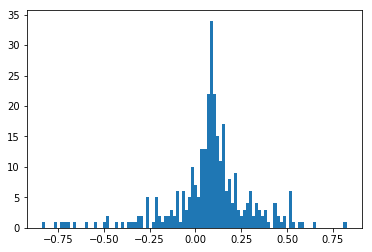

In [66]:
cl = 2
plt.hist(TX[classes==cl], bins=100);

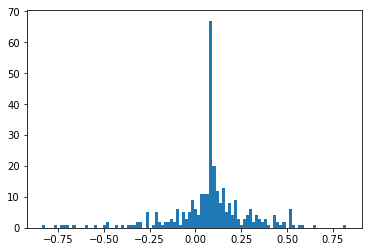

In [67]:
plt.hist(TX_m[classes==cl], bins=100);

## Подсчёт ядровых растояний

Для каждого трека считается расстояние до его k соседа. Это делает алгоритм более робастным к кластерам разной плотности.

In [16]:
k = 3

In [17]:
%%time
core_k = defaultdict(int)
for node_id in tqdm(G.nodes()):
    core_k[node_id] = np.partition([edge[2]['weight'] 
                                    for edge in G.edges(nbunch=[node_id], data=True)], k)[k]

100%|██████████| 7977/7977 [00:43<00:00, 182.08it/s]

CPU times: user 40.6 s, sys: 3.31 s, total: 44 s
Wall time: 43.8 s


## Строим граф попарных расстояний

Расстояние между двумя треками = максимум(ядровое расстояние трека_1, ядровое расстояние трека_1, расстояние(трек_1, трек_2)).

Такое определение расстояния обеспечивает робастность в алгоритме HDBSCAN.

In [18]:
# create self loops for HDBSCAN algorithm
# for node_id in tqdm(core_k.keys()):
#    G.add_edge(node_id, node_id, weight=core_k[node_id])

In [19]:
%%time
for node_id_left, node_left in tqdm(graphx.nodes(data=True)):
    for node_id_right, node_right in graphx.nodes(data=True):
        if node_left['features']['SZ'] < node_right['features']['SZ']:
            G.add_edge(u_of_edge=node_id_left, v_of_edge=node_id_right, 
                       weight=max(
                           core_k[node_id_left], 
                           core_k[node_id_right], 
                           #rms_integral_root_closed(node_left, node_right),
                           rms_integral_root_closed(node_left, node_right, TX_RIGHT='TX_m', TY_RIGHT='TY_m'),
                           #rms_integral_root_closed(node_left, node_right, TX_LEFT='TX_m', TY_LEFT='TY_m'),
                           #rms_integral_root_closed(node_left, node_right, TX_LEFT='TX_m', TY_LEFT='TY_m', TX_RIGHT='TX_m', TY_RIGHT='TY_m')
                       ))
            G.node[node_id_left].update(node_left)
            G.node[node_id_right].update(node_right)

100%|██████████| 7977/7977 [06:24<00:00, 20.74it/s]

CPU times: user 6min 17s, sys: 7 s, total: 6min 24s
Wall time: 6min 24s


## Построение минимального остовного дерева

На основе графа G строится минимальный остов, т.е. дерево, которое содержит в себе все вершины и сумма весов рёбер минимальна.

Для направленного графа это не работает, так как алгоритм выходит за границы памяти.

In [44]:
%%time
# G_mst = nx.tree.branchings.minimum_spanning_arborescence(G)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.9 µs


In [20]:
%%time
G_mst = nx.minimum_spanning_tree(G)

CPU times: user 4min 25s, sys: 16.2 s, total: 4min 42s
Wall time: 4min 42s


## Вытаскиваем рёбра из минимального остова

In [21]:
edges = list(G_mst.edges(data=True))
edges = [(edge[0], edge[1], edge[2]['weight']) for edge in edges]
edges = sorted(edges, key=lambda x: x[2])

In [22]:
edges_groups = defaultdict(list)
for edge in edges:
    edges_groups[edge[2]].append((edge[0], edge[1]))

## Объявляем необходимые структуры данных для кластеризации

In [23]:
from copy import deepcopy
def merge_clusters(clusters: list, cl_size: int, weight: float):
    true_clusters = []
    noise_clusters = []
    for cluster in clusters:
        if cluster.is_cluster:
            true_clusters.append(cluster)
        else:
            noise_clusters.append(cluster)
            
    if len(true_clusters) == 1:
        resulted_cluster = true_clusters[0].append(weight=weight, clusters=noise_clusters)
    else:
        resulted_cluster = ClusterHDBSCAN(weight=weight, cl_size=cl_size, clusters=clusters)
    
    return resulted_cluster

def find_cluster_with_node(clusters, node):
    for cluster in clusters:
        if node in cluster:
            return cluster
        
def calc_stabilities(root):
    root.calculate_stability()
    for child in root:
        calc_stabilities(child)
        
        
class ClusterHDBSCAN(object):
    def __init__(self, weight: float, cl_size: int, clusters: list = None, nodes: list = None):
        # init
        self.nodes = set()
        self.weights_nodes_dict = defaultdict(set)
        
        self.weight_death = weight
        self.lambda_death = 1. / weight
        
        self.weight_birth = weight
        self.lambda_birth = 1. / weight
        
        
        self.children = []
        self.falling_out_points = []
        
        assert clusters is not None or nodes is not None
        if clusters is not None:
            for cluster in clusters:
                self.nodes.update(cluster.nodes)
                self.weights_nodes_dict[weight].update(cluster.nodes)
                if cluster.is_cluster:
                    cluster.set_weight_birth(weight)
                    self.children.append(cluster)
                else:
                    self.falling_out_points.append(cluster)
        else:
            self.nodes.update(nodes)
            self.weights_nodes_dict[weight].update(nodes)
            
        self.is_cluster = len(self) >= cl_size
        self.is_noise = not self.is_cluster
        self.stability = None
        
        
    def append(self, weight: float, clusters: list):
        """
        Adding noise
        """
        for cluster in clusters:
            self.nodes.update(cluster.nodes)
            self.weights_nodes_dict[weight].update(cluster.nodes)
        self.weight_birth = weight
        self.lambda_birth = 1 / weight
        return self
    
    def __iter__(self):
        for child in self.children:
            yield child
    
    def __contains__(self, node):
        return node in self.nodes
    
    def __len__(self):
        return len(self.nodes)
    
    def set_weight_birth(self, weight: float):
        self.weight_birth = weight
        self.lambda_birth = 1 / weight
        
    def calculate_stability(self):
        self.stability = 0.
        for weight in self.weights_nodes_dict:
            self.stability += len(self.weights_nodes_dict[weight]) * (1. / weight - self.lambda_birth)

## Сам алгоритм

Идея алгоритма: есть дерево из которого можно удалять рёбра начиная с самого тяжёлого.

Удалив одно ребро сразу получим два кластера. Два ребра -- три кластера и т.д.

Вес ребра, после удаления которого появляется кластер, называется весом рождения кластера. Вес ребра, после удаления которого кластер исчезает(разбивается на два или количество вершин < порога), называется весом смерти кластера.

Если от удаления ребра кластер не распадается на два, а, к примеру, теряет "небольшое" число точек, то говорят, что кластер "теряет точки".

In [50]:
# minimal cluster size
cl_size = 50

In [51]:
%%time
clusters = []
for node_id in G_mst.nodes():
    clusters.append(ClusterHDBSCAN(cl_size=cl_size, weight=np.inf, nodes=[node_id]))
    
for weight in tqdm(edges_groups):
    clusters_to_merge_pairs = []
    for i, j in edges_groups[weight]:
        clusters_to_merge_pairs.append([find_cluster_with_node(clusters, i), find_cluster_with_node(clusters, j)])
    g = nx.Graph()
    for clusters_to_merge_pair in clusters_to_merge_pairs:
        g.add_path(clusters_to_merge_pair)
    for clusters_to_merge in nx.connected_components(g):
        for cluster in clusters_to_merge:
            clusters.remove(cluster)
        cluster = merge_clusters(clusters=clusters_to_merge, cl_size=cl_size, weight=weight)
        clusters.append(cluster)

100%|██████████| 7397/7397 [00:12<00:00, 612.42it/s]

CPU times: user 12.1 s, sys: 72 ms, total: 12.2 s
Wall time: 12.1 s


## Извлекаем корень дерева

In [52]:
root = clusters[0]

## Считаем стабильности

Для каждого кластера мы знаем вес ребра, когда он был создан, и вес ребра, когда он умер. Кроме того, от кластера могли отслаиваться точки во время жизни. 

По этим величинам можно посчитать стабильность кластера, которая характеризует насколько долго он жил.

In [53]:
calc_stabilities(root)

In [54]:
root.stability

26.71957441814968

In [55]:
root.children[0].stability

1.8163927319026683

In [56]:
root.children[1].stability

0.49499405188382095

## Стабильности

In [57]:
def reed_stabilities(root, level=0):
    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)), end=' ')
    print('stability={:.2f}'.format(root.stability))
    for child in root:
        reed_stabilities(child, level + 1)

In [58]:
reed_stabilities(root)

len=7977 stability=26.72
+---len=3084 stability=1.82
    +---len=2331 stability=20.95
    +---len=534 stability=1.58
        +---len=102 stability=0.20
        +---len=190 stability=1.53
+---len=379 stability=0.49
    +---len=134 stability=0.65
    +---len=163 stability=1.42


In [59]:
def class_disbalance(cluster, graph):
    subgraph = graph.subgraph(cluster.nodes)
    signal = []
    for _, node in subgraph.nodes(data=True):
        signal.append(node['signal'])
    return list(zip(*np.unique(signal, return_counts=True)))

In [60]:
def print_class_disbalance_for_all_clusters(root, graph, level=0):
    class_disbalance_tuples = class_disbalance(root, graph)

    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)))
    print('    ' * (level), end='')
    print(class_disbalance_tuples)
    print()
    for child in root:
        print_class_disbalance_for_all_clusters(child, graph, level + 1)

In [61]:
print_class_disbalance_for_all_clusters(root, G_mst)

len=7977
[(0.0, 2628), (1.0, 3542), (2.0, 313), (3.0, 505), (4.0, 595), (5.0, 394)]

+---len=3084
    [(0.0, 6), (1.0, 2488), (3.0, 287), (4.0, 303)]

    +---len=2331
        [(0.0, 4), (1.0, 2327)]

    +---len=534
        [(0.0, 1), (3.0, 259), (4.0, 274)]

        +---len=102
            [(3.0, 102)]

        +---len=190
            [(4.0, 190)]

+---len=379
    [(0.0, 2), (2.0, 197), (5.0, 180)]

    +---len=134
        [(2.0, 1), (5.0, 133)]

    +---len=163
        [(2.0, 163)]



In [105]:
def plot_class_disbalance_for_all_clusters(root, graph, level=0):
    
    class_disbalance_tuples = class_disbalance(root, graph)
    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)))
    print('    ' * (level), end='')
    print(class_disbalance_tuples)
    print()
    
    subgraph = graph.subgraph(root.nodes)
    plot_graphx(subgraph)
    
    for child in root:
        plot_class_disbalance_for_all_clusters(child, graph, level + 1)

len=7977
[(0.0, 2628), (1.0, 3542), (2.0, 313), (3.0, 505), (4.0, 595), (5.0, 394)]



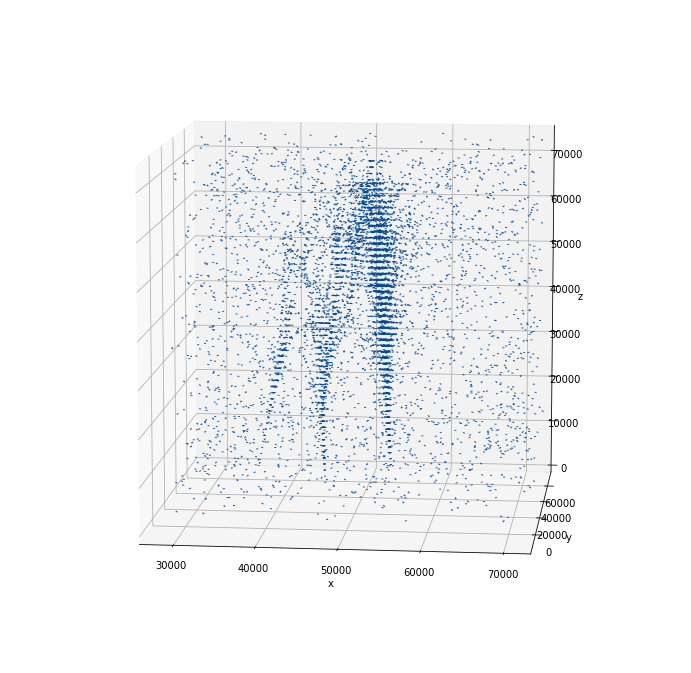

+---len=3361
    [(0.0, 12), (1.0, 2672), (3.0, 327), (4.0, 350)]



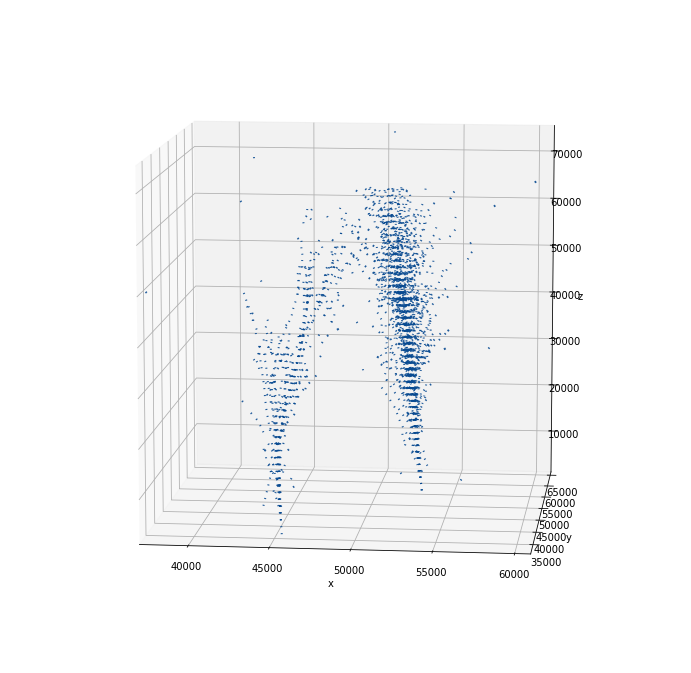

    +---len=644
        [(0.0, 4), (3.0, 310), (4.0, 330)]



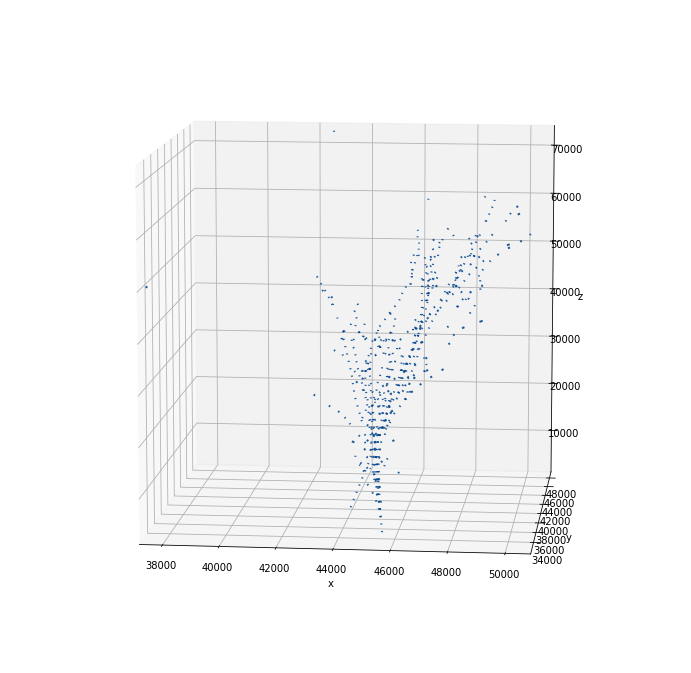

        +---len=213
            [(3.0, 1), (4.0, 212)]



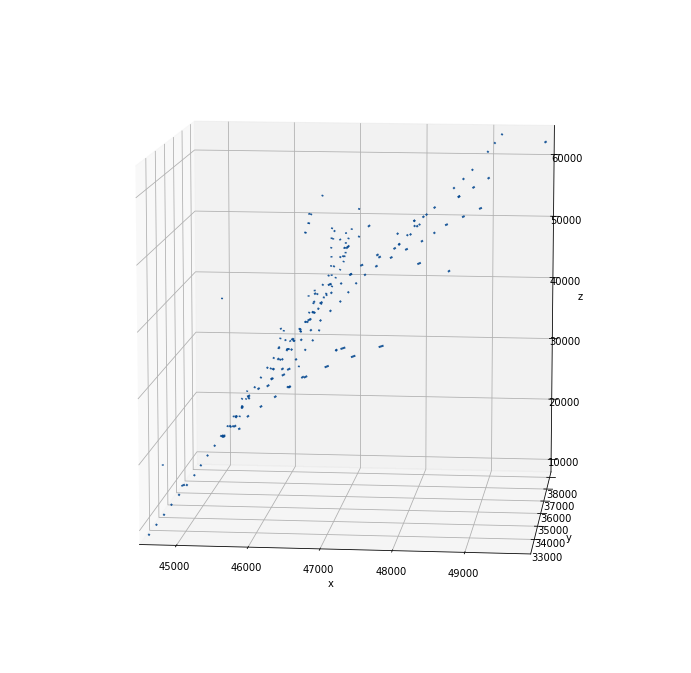

        +---len=161
            [(3.0, 161)]



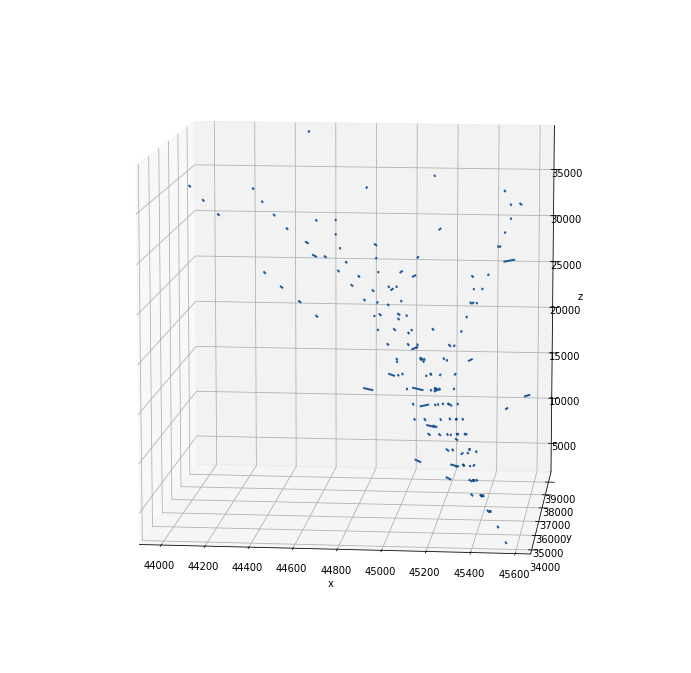

    +---len=2549
        [(0.0, 5), (1.0, 2544)]



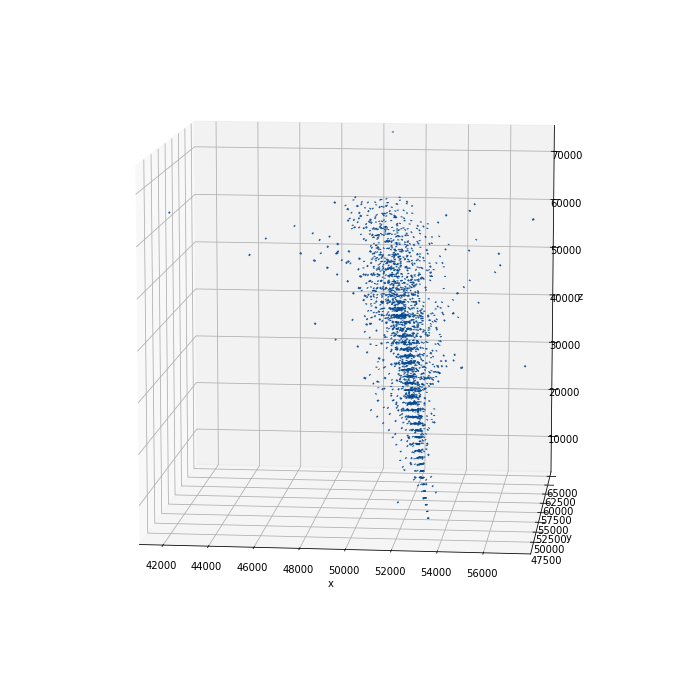

+---len=424
    [(0.0, 3), (2.0, 211), (5.0, 210)]



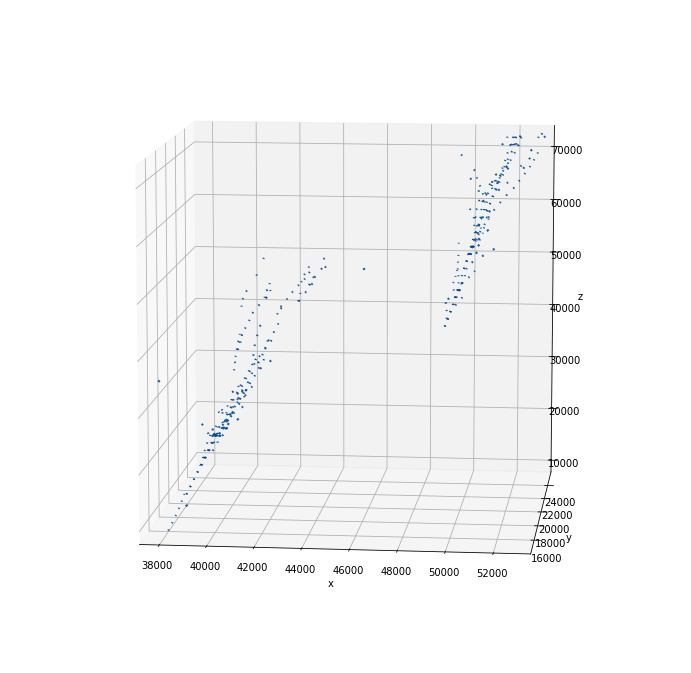

    +---len=126
        [(5.0, 126)]



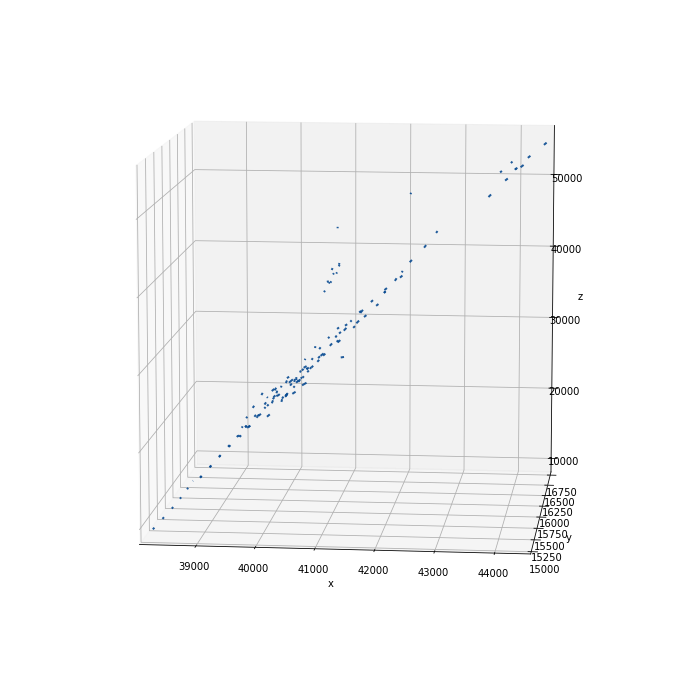

    +---len=151
        [(2.0, 151)]



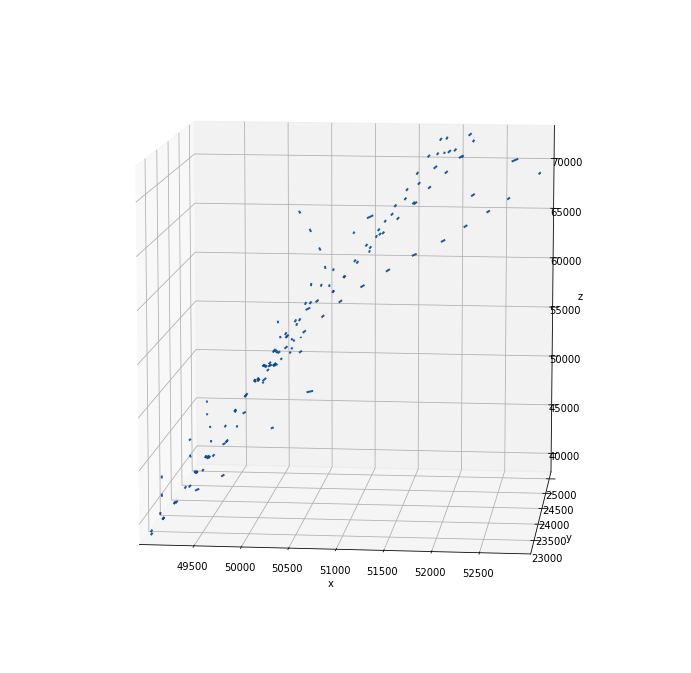

In [106]:
plot_class_disbalance_for_all_clusters(root, G_mst)